# CNN with MNIST

In [1]:
import torch
import torch.nn.init
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate = 0.001
training_epochs = 10
batch_size = 100

In [4]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)
mnist_test = datasets.MNIST(root='MNIST_data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [5]:
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        # Conv      ->(?, 28, 28, 32)
        # Pool      ->(?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten()
        )
        
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(data_loader)
print('total_batch : {}'.format(total_batch))

for epoch in range(training_epochs):
    
    avg_cost = 0
    
    for X, Y in data_loader:
        
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

total_batch : 600
[Epoch:    1] cost = 0.229480714
[Epoch:    2] cost = 0.0602424666
[Epoch:    3] cost = 0.044064682
[Epoch:    4] cost = 0.0355889425
[Epoch:    5] cost = 0.0293061864
[Epoch:    6] cost = 0.0254240409
[Epoch:    7] cost = 0.0205848813
[Epoch:    8] cost = 0.0186583288
[Epoch:    9] cost = 0.0146937231
[Epoch:   10] cost = 0.0123002995


# Grad-CAM

In [53]:
class LastConvLayerModel(nn.Module):
    def __init__(self):
        super(LastConvLayerModel, self).__init__()
        self.layers1 = list(list(model.children())[0].children())
        self.layers2 = list(list(model.children())[1].children())
        self.fc = list(model.children())[2]
    
    def forward(self, X_batch):
        x = self.layers1[0](X_batch)
        conv_layer_output = None
        
        for i, layer in enumerate(self.layers1[1:]):
            x = layer(x)
        
        for i, layer in enumerate(self.layers2):
            x = layer(x)
            if i == 0: 
                self.conv_layer_output = x
        
        x = self.fc(x)
        
        return x

In [70]:
import numpy as np

conv_model = LastConvLayerModel()
idx = np.random.choice(range(len(mnist_test)))
pred = conv_model(mnist_test[idx][0].unsqueeze(0))

In [71]:
print("Actual    Target : {}".format(mnist_test[idx][1]))
print("Predicted Target : {}".format(pred.argmax(dim=-1).item()))

Actual    Target : 8
Predicted Target : 8


In [72]:
from torch import autograd

grads = autograd.grad(pred[:, pred.argmax().item()], conv_model.conv_layer_output)

grads[0].shape

torch.Size([1, 64, 14, 14])

In [73]:
pooled_grads = grads[0].mean((0,2,3))

pooled_grads

tensor([ 1.8094e-03,  1.0543e-04, -1.0204e-03,  8.4164e-04, -6.5150e-05,
        -5.7436e-03,  8.6772e-04,  1.7115e-04, -4.5470e-04, -3.9296e-04,
         0.0000e+00,  8.6930e-04, -2.9333e-04, -3.4148e-03,  0.0000e+00,
         1.2706e-03,  1.7787e-03, -2.5044e-04,  0.0000e+00, -2.4953e-03,
         1.8709e-03, -9.0039e-04,  2.0826e-04,  2.6168e-03, -7.7358e-04,
         1.0449e-03,  7.5373e-04,  5.5995e-04,  2.4112e-03, -1.7935e-04,
         1.2796e-04, -4.3952e-03, -7.4962e-04,  0.0000e+00,  7.0448e-04,
         8.8861e-04, -1.9699e-03,  1.8297e-03, -2.5196e-04,  1.6604e-03,
        -2.0362e-04,  2.5947e-03,  2.6452e-03,  8.8987e-04, -7.2924e-04,
         4.5089e-04, -6.1115e-04, -6.2081e-05,  1.4219e-03,  1.7307e-03,
         1.7133e-03,  2.4987e-03, -4.1316e-04,  9.5023e-04,  1.1381e-03,
         0.0000e+00,  1.0109e-03,  2.6439e-03,  2.4895e-03,  2.9996e-03,
         1.3644e-04, -9.8297e-04, -2.5895e-03,  2.4407e-03])

In [74]:
conv_output = conv_model.conv_layer_output.squeeze()

conv_output = torch.nn.functional.relu(conv_output)

conv_output.shape

torch.Size([64, 14, 14])

In [75]:
for i in range(len(pooled_grads)):
    conv_output[i,:,:] *= pooled_grads[i]

conv_output.shape

torch.Size([64, 14, 14])

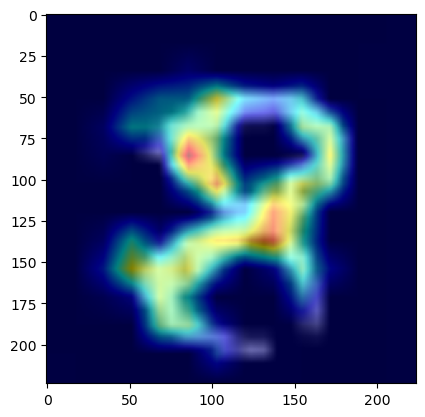

In [76]:
import cv2

mask = conv_output.mean(dim=0).squeeze()
mask = torch.relu(mask) / torch.max(mask)
mask = F.upsample_bilinear(mask.unsqueeze(0).unsqueeze(0), [224, 224])
mask = mask.cpu().detach().squeeze().numpy()

heatmap = cv2.applyColorMap(np.uint8(255 * (1-mask)), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap = heatmap / np.max(heatmap)

img = mnist_test[idx][0].numpy().squeeze()
img = np.float32(cv2.resize(img, (224, 224)))
img = img / np.max(img)
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

cam = heatmap + np.float32(img)
cam = cam / np.max(cam)
plt.imshow(np.uint8(255 * cam))
plt.show()

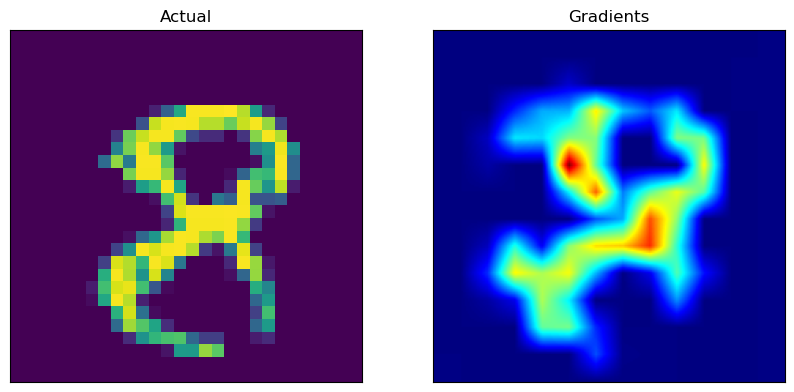

In [77]:
import matplotlib
import matplotlib.pyplot as plt

def plot_actual_and_heatmap(idx, heatmap):

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(mnist_test[idx][0].numpy().squeeze());
    ax1.set_title("Actual");
    ax1.set_xticks([],[]);ax1.set_yticks([],[]);

    ax2 = fig.add_subplot(122)
    ax2.imshow(heatmap);
    ax2.set_title("Gradients");
    ax2.set_xticks([],[]);ax2.set_yticks([],[]);

plot_actual_and_heatmap(idx, heatmap)